In [1]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
#read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one
X, Y = [], [] #X = Inputs, Y = Labels of our training data

for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)


emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [8]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [9]:
C = torch.randn((27,2)) # Cramming our 27 characters into a 2 dimensional lookup table (space)

In [11]:
C[5] # The letter E represented in the look up table

tensor([2.4311, 1.9565])

In [13]:
F.one_hot(torch.tensor(5), num_classes=27) #turning our 5 reprsentation into 0's and a single 1 at the 5th index

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [14]:
# one_hots are int64s, and torch can only matrix multiply floats
# this equivalent of doing C[5] as it will pull the value out of C but not needed as indexing C[5] is much faster
F.one_hot(torch.tensor(5), num_classes=27).float() @ C 


tensor([2.4311, 1.9565])

In [18]:
# We can also index with a list or a list of tensors
C[torch.tensor([5,6,7])]
C[X]
C[X].shape

torch.Size([32, 3, 2])

In [19]:
X[13, 2] #returns 1 because M is turned on

tensor(1)

In [20]:
C[X][13,2] #indexes and finds the embeding for M 

tensor([ 0.3945, -0.3639])

In [21]:
C[1] # the exact same as C[1]

tensor([ 0.3945, -0.3639])

In [22]:
# With this knoweldge, embedding in pytorch is really great
# Thus we can just create embeddings really easily like below
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [37]:
# Number of inputs will  be 6
# 3 embedings, each with 2 dimensions like seen agove in our emb.shape
# 100 is our number of neurons
# Biases will be a random 100 to match our neurons
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [26]:
# We need to concatenate our embeddigns in order to @ matrix mulitply with our weight matrix of 6 x 100
# Can see with the result that the 3, 2 from our emb shape is concat to 6
# However we need to make this more general so we can accept any block size later
torch.cat([emb[:,0,:], emb[:, 1, :], emb[:,2,:]], 1).shape # the ,1 is the dimension we want to cat with

torch.Size([32, 6])

In [29]:
# This is a better way, but not the best yet
torch.cat(torch.unbind(emb, 1), 1).shape #unbind returns a slice of the dimension thats input, in this case 1

torch.Size([32, 6])

In [30]:
# Example
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [31]:
# The view function is extremely efficent, an allow us to manipulate the tensor as long as new total equals the original
# For example 2 * 9 = 18, like our one dimensional tensor above, but this could also be 3, 3, 2 (3 * 3 * 2 = 18)
a.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [34]:
# Why is it so efficient?
# Every tensor is always represented as a 1 dimentional vector in memory
# Thus when we call .view(x,x) no memory is actually being changed or copied, just the view changes
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [35]:
# We can verify it works below
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1),1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [41]:
# Now with this knowledge we can set our hidden states (h)
# -1 will autmoatically infer what the first value should be, making it more flexible
# Remember how matrices broadcast in Pytroch from our first makemore demo
h = emb.view(-1, 6) @ W1 + b1
h.shape

torch.Size([32, 100])

In [42]:
# lets normalize our hidden states layer and normalize their values with tanh
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[-0.4888,  0.9998,  0.9901,  ..., -1.0000, -0.6675,  1.0000],
        [ 0.0268, -0.0977, -0.9663,  ..., -1.0000, -0.1690,  1.0000],
        [-0.9709, -0.9978,  0.9634,  ...,  0.2267,  0.0793,  0.9793],
        ...,
        [-0.5346,  0.4481,  0.9979,  ...,  0.6261, -0.7281,  0.7395],
        [-0.6741,  1.0000, -0.7885,  ..., -0.9999, -0.9947,  0.9975],
        [-0.9957,  0.9729,  1.0000,  ..., -0.9805, -0.9732,  0.9999]])

In [43]:
# Now lets create the outplut layer
W2 = torch.randn((100, 27)) #27 possible characters that come next
b2 = torch.randn(27)

In [46]:
logits = h @ W2 + b2
logits.shape #looks good

torch.Size([32, 27])

In [50]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob[0].sum() #every row now sums to 1, we're good

tensor(1.0000)

In [54]:
# Now lets index into the all rows of prob, and pluck out the correct probablity assigned to get our loss
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.8216)

In [ ]:
# ------------------------ All Steps Cleaned Up / Summarized For Eaiser Reading --------------------------

In [73]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one
X, Y = [], [] #X = Inputs, Y = Labels of our training data

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [74]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [128]:
g = torch.Generator().manual_seed(2147483647) # For reproducibility
C = torch.randn((27, 2), generator=g) # First layer
W1 = torch.randn((6, 100), generator=g) # Weights for our hidden layer
b1 = torch.randn(100, generator=g) # Biases for our hidden layer
W2 = torch.randn((100, 27), generator=g) # Weights for our last layer of logits
b2 = torch.randn(27, generator=g) # Biases for our last layer of logits
parameters = [C, W1, b1, W2, b2]


In [129]:
sum(p.nelement() for p in parameters) # number of parameters in total in our network

3481

In [130]:
for p in parameters:
    p.requires_grad = True

In [131]:
# We want to select random mini batches of the dataset since now our dataset is the full data
# Pull a minibatch size of 32 from our X.Shape at dimension 0 (28,000+ for our high side)
# torch.randint(low=0, high, size)
torch.randint(0,X.shape[0],(32, ))

tensor([ 86254, 197293, 215228,  90851,  32872, 118020,  59580,  22747, 141591,
         60127, 144142,  22075, 220362, 226804,  97222, 190567,  47750,  18234,
         90772, 150674, 177045, 210876,  59496,  48422,  31478,   3495, 174403,
        169077, 124662, 109683, 110727, 107660])

In [132]:
# Finding a good learning rate intead of manually tweaking it ourselves
lre = torch.linspace(-3, 0, 1000) #10**-3 = 0.0010 & 10**0 = 1
lrs = 10**lre


In [137]:
lri = []
lossi = []

for i in range(10000):

    # Our minibatch sample for speed of iteration instead of going over the entire dataset for training
    # This the quality of our graidnets will be lower, since the direction won't be as reliable
    # Better to take an approximate gradient, with more steps -> than an exact gradient and take fewer steps
    ix = torch.randint(0, X.shape[0], (32,))

    # Forward Pass
    emb = C[X[ix]] # (32, 3, 2) Embedding C with respect to X minibatch inputs -- First Layer
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100) -- Hidden Layer
    logits = h @ W2 + b2 # (32, 27) -- Final Layer

    # --------- Inefficient Old way of calculating loss because each line makes new tensors-------------------
    # counts = logits.exp() # remove negavie numbers from our logits
    # prob = counts / counts.sum(1, keepdim=True) #normalize the probablities and each row sums to 1
    # loss = -prob[torch.arange(32), Y].log().mean() # calculate negative loss likelihood with respect to Y, our training data

    # ------------- Efficent way with Pytorch using F.cross_entropy() --------------
    # All we do is  Pass in our last layer of logits, and the expected outputs of Y
    # Lets the Forward & backward pass be much more efficient and never have logits that go out of float bounds
    loss = F.cross_entropy(logits, Y[ix]) # Y[ix] is the expected output of the minibatch 

    # Backward Pass
    for p in parameters:
        p.grad = None # set gradients to 0
    loss.backward()

    #Update the parameters using our learning rate
    #lr = lrs[i]
    lr = 0.1 # 10**-1 -> based on our previous tracking thats now commented out, can also decay of 10x lower 0.01 for the final runs
    for p in parameters:
        p.data += -lr * p.grad

    # Track learning rate stats
    #lri.append(lre[i])
    #lossi.append(loss.item())
        
print(loss.item())

2.54235577583313


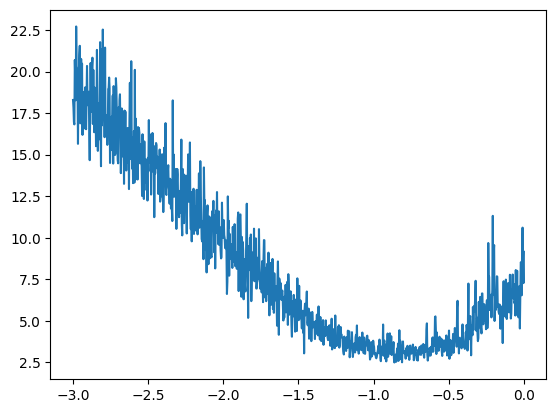

In [116]:
# We can now plot our learning rates vs the loss and see which is the most efficient for our training
plt.plot(lri, lossi)

In [138]:
# Calculate our loss on the whole training set to see how it compares to our minibatch loss
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3498, grad_fn=<NllLossBackward0>)

In [ ]:
# However, we never went to overfit our training set if the capacity of our parameters grows
# If this happens, our trained model will only ever output samples found in our training set, and never unique outputs
# Thus in practice, we can split the data set into 3 pieces

# Training  Split -- Dev/Validation Split -- Test Split
# 80%                10%                      10%

# Training split is used to train the parameters
# Dev/Validation split is used to train the hyper parameters (different number of parameters in the layers)
# Test split to evaulate the performance at the very end -> THE LOSS CAN ONLY BE TESTED HERE, FEW TIMES


# ----------------------------------------- THE FINAL SET UP BELOW --------------------------------------------


In [139]:
import random

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one
    X, Y = [], [] #X = Inputs, Y = Labels of our training data
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) #80% of the words
n2 = int(0.9*len(words)) #90% of the words

Xtr, Ytr = build_dataset(words[:n1]) #25,625 words
Xdev, Ydev = build_dataset(words[n1:n2]) # n2 - n1 = 3203 words
Xte, Yte = build_dataset(words[n2:]) # len(words) - n2 = 3204 words

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [140]:
# Our Dataset for training
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [146]:
g = torch.Generator().manual_seed(2147483647) # For reproducibility
C = torch.randn((27, 2), generator=g) # First layer
W1 = torch.randn((6, 100), generator=g) # Weights for our hidden layer
b1 = torch.randn(100, generator=g) # Biases for our hidden layer
W2 = torch.randn((100, 27), generator=g) # Weights for our last layer of logits
b2 = torch.randn(27, generator=g) # Biases for our last layer of logits
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [147]:
# Calculate learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [150]:
lri = []
lossi = []

for i in range(10000):

    # Our minibatch sample for speed of iteration over our 80% dataset
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward Pass
    emb = C[Xtr[ix]] # (32, 3, 2) Embedding C with respect to X minibatch inputs -- First Layer
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100) -- Hidden Layer
    logits = h @ W2 + b2 # (32, 27) -- Final Layer
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Backward Pass
    for p in parameters:
        p.grad = None 
    loss.backward()

    #Update the parameters
    #lr = lrs[i]
    lr = 0.1 
    for p in parameters:
        p.data += -lr * p.grad

    # Track learning rate stats
    #lri.append(lre[i])
    #lossi.append(loss.item())
        
print(loss.item())

2.149198293685913


In [152]:
#Calculate loss on our training split
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3211, grad_fn=<NllLossBackward0>)

In [151]:
# Calculate our loss on our Dev split
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3240, grad_fn=<NllLossBackward0>)

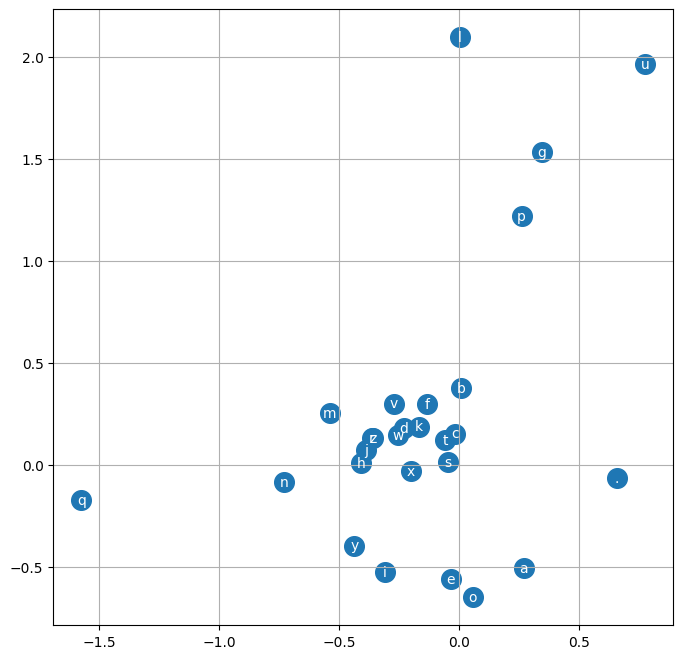

In [153]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [154]:
# Sampling our current model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # intialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, dimension)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

careah.
ami.
havifkirri.
rehty.
salassa.
jaronte.
delyaht.
kaqui.
nerania.
chaiiv.
kaleigbh.
bha.
din.
quinn.
sroilea.
jadiquin.
elo.
dearyni.
jaye.
pius.


In [ ]:
# Since our training split loss is almost equal to our developer split loss, we know we're underfitting
# This is due to our total parameters being small, we can change the size of our model by increasing the total parameters and/or our character embedding size
# The more parameters, the lower the loss could eventually be and get towards 0
# We can also adjust the number of characters the model samples at a time instead of 3
# We can also increase the batch size of our training set
# All of these are for the homework assignment below

In [ ]:
# ---------------------------------- HOMEWORK EXERCISE (Beat 2.1260 tr & 2.1701 dev loss from Andre) -----------------------------------

In [198]:
import random

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one
    X, Y = [], [] #X = Inputs, Y = Labels of our training data
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) #80% of the words
n2 = int(0.9*len(words)) #90% of the words

Xtr, Ytr = build_dataset(words[:n1]) #25,625 words
Xdev, Ydev = build_dataset(words[n1:n2]) # n2 - n1 = 3203 words
Xte, Yte = build_dataset(words[n2:]) # len(words) - n2 = 3204 words

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [199]:
# Our Dataset for training
Xtr.shape, Ytr.shape

(torch.Size([182441, 3]), torch.Size([182441]))

In [202]:
g = torch.Generator().manual_seed(2147483647) # For reproducibility
C = torch.randn((27, 20), generator=g) # First layer
W1 = torch.randn((60, 200), generator=g) # Weights for our hidden layer
b1 = torch.randn(200, generator=g) # Biases for our hidden layer
W2 = torch.randn((200, 27), generator=g) # Weights for our last layer of logits
b2 = torch.randn(27, generator=g) # Biases for our last layer of logits
parameters = [C, W1, b1, W2, b2]

In [203]:
sum(p.nelement() for p in parameters) # Number of total parameters in our network

18167

In [204]:

for p in parameters:
    p.requires_grad = True

In [205]:
# Calculate learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [206]:
lri = []
lossi = []
stepi = []

In [207]:
for i in range(200000):

    # Our minibatch sample for speed of iteration over our 80% dataset
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward Pass
    emb = C[Xtr[ix]] # (32, 10, 2) Embedding C with respect to X minibatch inputs -- First Layer
    h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # (32, 200) -- Hidden Layer
    logits = h @ W2 + b2 # (32, 27) -- Final Layer
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Backward Pass
    for p in parameters:
        p.grad = None 
    loss.backward()

    #Update the parameters
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track learning rate stats
    stepi.append(i)
    lossi.append(loss.log10().item())
        
print(loss.item())

2.1892263889312744


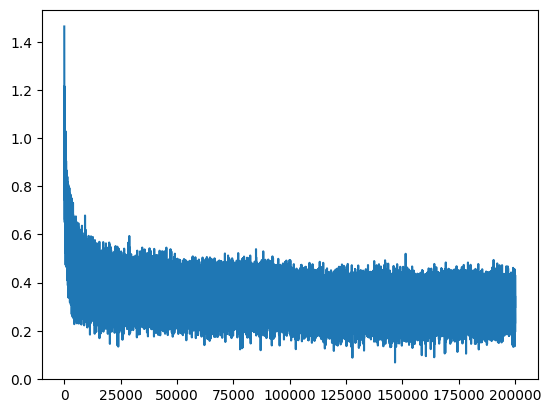

In [208]:
plt.plot(stepi, lossi)

In [210]:
#Calculate loss on our training split
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 60) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0680, grad_fn=<NllLossBackward0>)

In [212]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 60) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1440, grad_fn=<NllLossBackward0>)

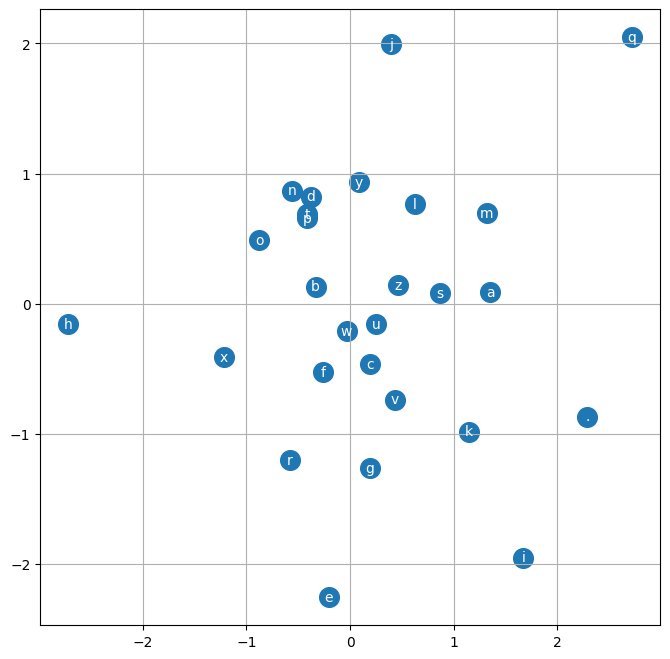

In [213]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [214]:
# Sampling our current model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # intialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, dimension)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carman.
amillivitchmyli.
taty.
skanden.
jazzuel.
deliah.
jarqui.
nellara.
chaiirie.
leggyn.
lucio.
sherinnis.
lilea.
jadique.
jero.
deartin.
jacee.
dus.
brey.
edii.


In [ ]:
#---------------------------------- END OF LESSON -------------------------------------
# Was able to beat andre's by increasing the number of embeddings in the C look up table to 20 intead of 2
# Which in turn increased the number of weights to 60 instead of 6.
# So by increasing the look up table dimentiality & weights by a factor of 10, we were able to improve the loss function a good amount